# Advection-Diffusion Equation

Jupyter script to illustrate numerical integration, using upwind and central finite differences.

Philipp Schlatter, October 2021

---

## Preliminaries

Initialisation of the graphics:

In [18]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.animation
from math import pi
params = {'legend.fontsize': 12,
          'legend.loc':'best',
          'figure.figsize': (8,5),
          'lines.markerfacecolor':'none',
          'axes.labelsize': 12,
          'axes.titlesize': 12,
          'xtick.labelsize':12,
          'ytick.labelsize':12,
          'grid.alpha':0.6}
pylab.rcParams.update(params)

Definition of our initial condition, domain size and discretisation points. Here, we take either a wave packet, simply defined as 

$$f_1(x) = \sin(2 x) \cdot e^{-x^2/20} \ ,$$

or a square wave (top-hat signal, $f_2(x)$). A third option is a single blop centred around $x=0$,

$$f_3(x) = \cos(x/5) \cdot e^{-x^2/10} \ .$$



In [19]:
# Wavepacket
f1 = lambda  x: np.sin(2*x)*np.exp(-x**2/20)
# Square wave (top-hat function)
f2 = lambda x: np.array([1 if (t>=-18 and t<=-16) else 0 for t in x])
# one blob
f3 = lambda x: np.cos(x/5)*np.exp(-x**2/10)

In [20]:
# physical quantities
L=40
T=40
c=2

# numerical quantities
nx=200
dt=0.1

# create data
dx=L/nx    
x=np.linspace(-L/2,L/2,num=nx,endpoint=False)
nt = int(T/dt)+1
t=np.linspace(0,T,num=nt)

# set initial condition (f1, f2 or f3)
u0=f1(x)

<IPython.core.display.Javascript object>


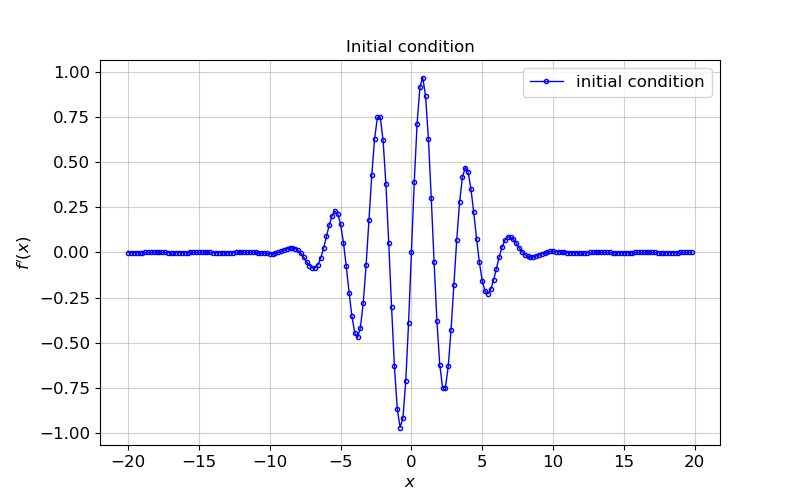

In [21]:
# Plot initial condition    
pp=plt.figure()
plt.title('Initial condition')
plt.plot(x,u0,'.-b',lw=1,label='initial condition')
plt.xlabel(r'$x$')
plt.ylabel(r'$f^\prime(x)$')
plt.grid()
plt.legend(loc='upper right')
plt.show()


---

## Advection Equation

In a first step, we consider the advection equation, i.e. the differential equation

$$\frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = 0 \ .$$

The solution can be obtained via the method of characteristics, and yields

$$u(x,t) = u(x-ct,0) = u_0(x-ct)$$

with the initial condition $u_0(x)$. In a periodic domain ($u(-20)=u(20)$), we do not need to provide addition inflow/outflow conditions (discussion related to type of partical differential equation, see course literature).

Compute the numerical solution, using an upwind scheme in space and time (**FTBS** - forward time backward space). This scheme is, as discussed earlier, stable for Courant number $$0<\sigma=c\frac{\Delta t}{\Delta x}<1$$.

In [22]:
sigma = c*dt/dx
nux = 0.5*c*dx
nut = -0.5*c*dx*sigma
print(f"Courant number sigma={sigma:.2f} (<=1 for stability)")
print(f"numerical viscosity nux={nux:.5f}   nut={nut:.5f}")

u1=np.zeros((nx,nt))
for i in range(0,nx):
    u1[i,0] = u0[i]
    
# FTBS scheme for the advection equation
for j in range(1,nt):
    for i in range(0,nx):
        u1[i,j] = u1[i,j-1] - c*dt/dx*( u1[i,j-1]-u1[i-1,j-1])

Courant number sigma=1.00 (<=1 for stability)
numerical viscosity nux=0.20000   nut=-0.20000


<IPython.core.display.Javascript object>


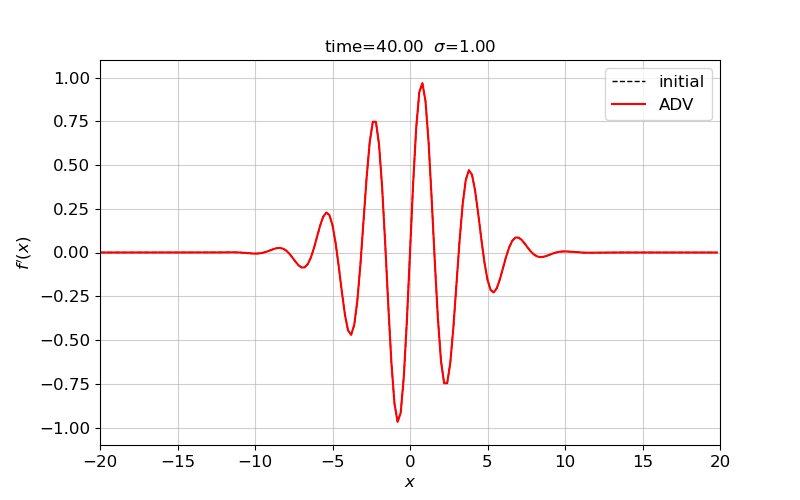

In [23]:
#plt.rcParams["animation.html"] = "jshtml"
#plt.ion()

fig = plt.figure(figsize=(8,5))

def animate(j):
    plt.cla()
    plt.xlabel('$x$')
    plt.ylabel('$f^\prime(x)$')
    plt.grid()
    plt.plot(x,u0,'k--',lw=1,label='initial')
    plt.plot(x,u1[:,4*j],'r',label='ADV')
    plt.xlim(-20,20)
    plt.ylim(-1.1,1.1)
    plt.title(f"time={t[4*j]:.2f}  $\sigma$={sigma:.2f}")  
    plt.legend(loc='upper right')
    
ani=matplotlib.animation.FuncAnimation(fig, animate, frames=int((t.size-1)/4+1), repeat=False)
#writer = matplotlib.animation.writers['ffmpeg']
#writer = writer(fps=24)
#ani.save('out.mp4', writer=writer)

We can make the following observations:
* if the Courant number is $\sigma=1$, then the FTBS discretistaion does not introduce any numerical dissipation or dispersion, and you recover the exact solution.
* if $\sigma<1$, the solution will decay over time due to numerical dissipation (*dissipative scheme*)
* for $\sigma>1$, the FTBS scheme is unstable, i.e. the solution will grow over time and eventually explode.

Play with the various parameters ($\Delta x$, $\Delta t$, $c$, initial condition).

---

## Advection-Diffusion equation

In a second step, we consider the advection-diffusion equation, i.e. 

$$ \frac{\partial u}{\partial t} + c\frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2} \ .$$

The solution is obviously pure advection for $\nu=0$, and adds a certain amount of dissipation for $\nu>0$. Exponential growth is expected for $\nu<0$, and the problem is not well-posed anymore.

Here we discretise the equation using explicit Euler in time and central differences in space.


In [9]:
nu = 0.02    # stable for nu=0.05, unstable for nu<0.5

sigma = c*dt/dx
beta = nu*dt/(dx**2)
nux = 0.5*c*dx
nut = -0.5*c*dx*sigma
print(f"Courant number sigma={sigma:.2f}")
print(f"               beta={beta:.2f} (<=1/2 for stability)")
print(f"sigma^2/beta ={sigma**2/beta:.2f} (<=2 for stability)")
print(f"numerical viscosity nux={nux:.5f}   nut={nut:.5f}")
print(f"wikipedia: {dx*c/nu:.5f} (<=2) WRONG!")

u2=np.zeros((nx,nt))
for i in range(0,nx):
    u2[i,0] = u0[i]
    
# FTCS scheme for the advection-diffusion equation
for j in range(1,nt):
    for i in range(0,nx):
        u2[i,j] = u2[i,j-1]   \
                 - c*dt/(2*dx)*( u2[(i+1)%nx,j-1]-u2[i-1,j-1] ) \
                 + nu*dt/(dx**2)*( u2[(i+1)%nx,j-1]-2*u2[i,j-1]+u2[i-1,j-1]  )

Courant number sigma=0.50
               beta=0.05 (<=1/2 for stability)
sigma^2/beta =5.00 (<=2 for stability)
numerical viscosity nux=0.10000   nut=-0.05000
wikipedia: 10.00000 (<=2) WRONG!


<IPython.core.display.Javascript object>


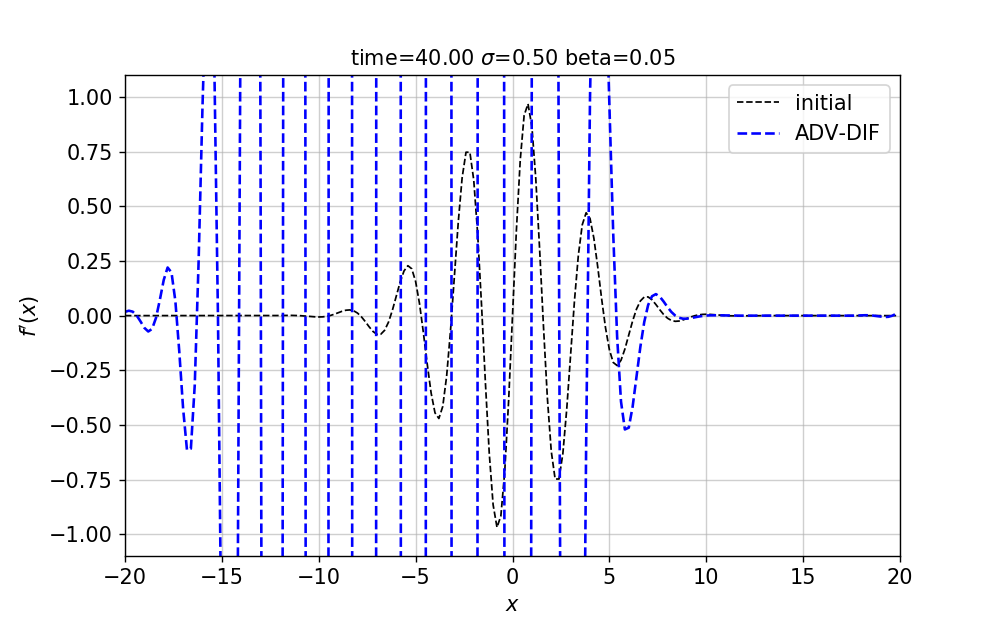

In [10]:
#plt.rcParams["animation.html"] = "jshtml"
#plt.ioff()

fig = plt.figure(figsize=(8,5))

def animate(j):
    plt.cla()
    plt.xlabel('$x$')
    plt.ylabel('$f^\prime(x)$')
    plt.grid()
    plt.plot(x,u0,'k--',lw=1,label='initial')
    #plt.plot(x,u1[:,4*j],'r',label='ADV')
    plt.plot(x,u2[:,4*j],'b--',label='ADV-DIF')
    plt.xlim(-20,20)
    plt.ylim(-1.1,1.1)
    plt.title(f"time={t[4*j]:.2f} $\sigma$={sigma:.2f} beta={beta:.2f}")   
    plt.legend(loc='upper right')
    
ani=matplotlib.animation.FuncAnimation(fig, animate, frames=int((t.size-1)/4+1), repeat=False)
#writer = matplotlib.animation.writers['ffmpeg']
#writer = writer(fps=24)
#ani.save('out.mp4', writer=writer)

Good cases to try (for $L=40$, $c=1$, $\nu=0.05$):
* nx=400, dt=0.1: Then we get $\sigma=1$ and $\beta=0.5$ and $\sigma^2/\beta=2$. Observation: solution to advection and advection-diffusion equation are exactly the same, and correspond to pure advection! Why? Check the numerical viscosity of the FTBS scheme. Why is the solution constant even though $\nu_{num}>0$?
* nx=400, dt=0.01: Solution is decaying, identical for both advection and advection-diffusion equation. Why? Check again the numerical viscosity of the FTBS scheme. Why does a smaller time step lead to a decaying solution?
* nx=200, dt=0.1: The advection equation with $\sigma=0.5$ is very dissipative and decays fast. The ADV-DIF solution is decaying slower, however with clear dispersion errors. Why?
* nx=200, dt=0.11: Advection-diffusion equation is unstable, advection alone is stable. The time step limit of diffusion was violated.
* nx=200, dt=0.01: Both solutions are much more damped, because of the properties of the temporal scheme.

---

## Stability and truncation error

The stability for the advection and diffusion equations separately are:
* $\sigma = c\frac{\Delta t}{\Delta x} \leq 1$ (note only necessary as based on CFL condition)
* $\beta = \nu \frac{\Delta t}{\Delta x^2} \leq 1/2$ (necessary and sufficient)

However, for the coupled advection-diffusion equation one gets the following

$$\sigma^2\leq 2\beta \leq 1$$

which can be re-written as two inequalities:
* $\beta \leq 1/2$: $\Delta t\leq \frac{1}{2\nu}\Delta x^2$ (as for diffusion equation)
* $\sigma^2/\beta \leq 2$: $\Delta t\leq 2\nu/ c^2$ (independent of $\Delta x$)

One observes the following
* for high viscosity the diffusive term is dominant: *viscous time-step limit*
* for low viscosity: advection is stabilised by viscosity
* for zero viscosity ($\nu=0$): maximum $\Delta t=0$, i.e. the scheme is unconditionally unstable (central discretisation of advection is always unstable)


The truncation error for the upwind scheme is
$$T(x_j,t^n) = \frac{1}{2}c \Delta x u_{xx} - \frac{1}{2} \Delta t u_{tt} $$

and thus the numerical viscosity for the spatial scheme

$$ \nu_{num} = \frac{1}{2}c \Delta x  \ , $$
 
and the numerical viscosity for the temporal scheme (Euler forward) is

$$ \nu_{num,t} = -\frac{1}{2} c^2 \Delta t \ .$$

For the advection-diffusion scheme we have no diffusive errors in space (i.e. $\nu_{num}=0$).

<IPython.core.display.Javascript object>


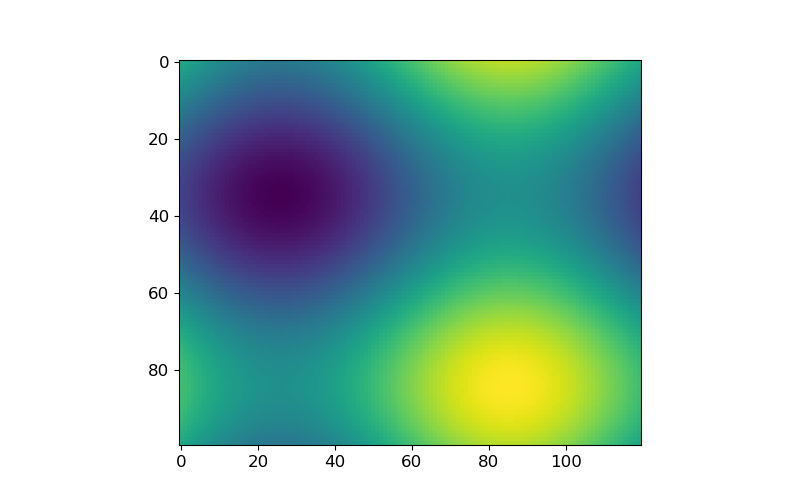

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()